In [1]:
using Distributions
using RCall
using StatsPlots

default(fmt=:png, titlefontsize=10)
@rlibrary stats

function pvalue_clopper_pearson(model::DiscreteUnivariateDistribution, data)
    min(1, 2cdf(model, data), 2ccdf(model, data-1))
end

x ⪅ y = x < y || x ≈ y

function pvalue_sterne(model::DiscreteUnivariateDistribution, data)
    p0 = pdf(model, data)
    m = mode(model)
    pdf(model, m) ≈ p0 && return 1.0
    if data > m
        i = m - 1
        while !(pdf(model, i) ⪅ p0) i -= 1 end
        return cdf(model, i) + ccdf(model, data-1)
    else # data < m
        i = m + 1
        while !(pdf(model, i) ⪅ p0) i += 1 end
        return cdf(model, data) + ccdf(model, i-1)
    end
end

label = ["Sterne" "Clopper-Pearson" "R"]
ls = [:solid :dash :dashdot]
ytick = 0:0.05:1
xguide = "data"
yguide = "P-value"

"P-value"

model = Binomial{Float64}(n=20, p=0.5)
datas = 0:20


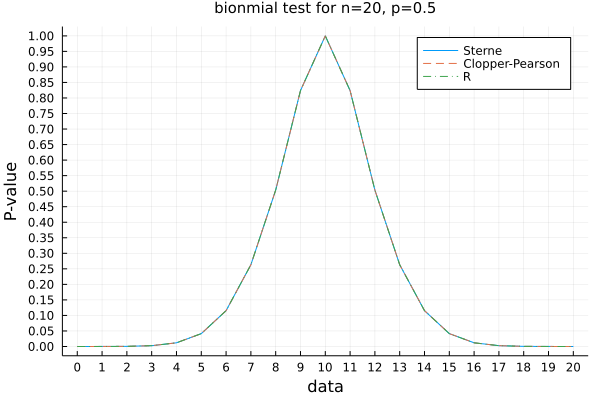

In [2]:
n, p = 20, 0.5
model = Binomial(n, p)
datas = support(model)
pvals = [
    pvalue_sterne.(model, datas);;
    pvalue_clopper_pearson.(model, datas);;
    [rcopy(binom_test(x, n; p))[:p_value] for x in datas]
]
@show model datas
plot(datas, pvals; label, ls, xtick=datas, ytick, xguide, yguide)
title!("bionmial test for n=$n, p=$p")

model = Binomial{Float64}(n=20, p=0.37)
datas = 0:20


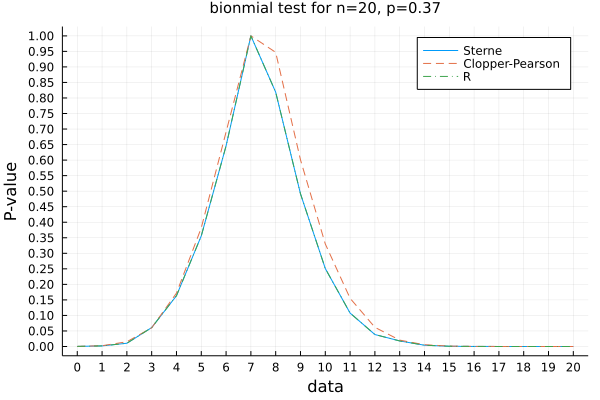

In [3]:
n, p = 20, 0.37
model = Binomial(n, p)
datas = support(model)
pvals = [
    pvalue_sterne.(model, datas);;
    pvalue_clopper_pearson.(model, datas);;
    [rcopy(binom_test(x, n; p))[:p_value] for x in datas]
]
@show model datas
plot(datas, pvals; label, ls, xtick=datas, ytick, xguide, yguide)
title!("bionmial test for n=$n, p=$p")

model = Hypergeometric(ns=19, nf=21, n=15)
datas = 0:15


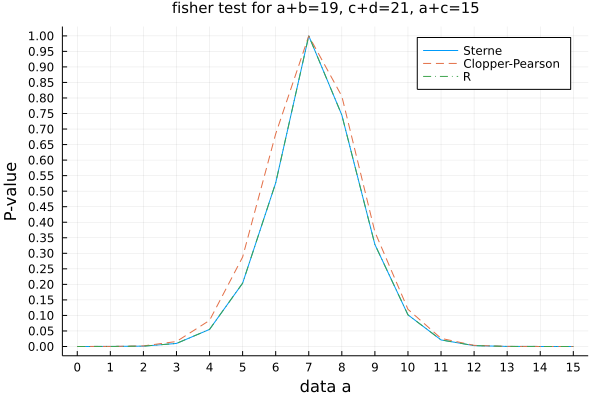

In [4]:
m, n, r = 19, 21, 15
model = Hypergeometric(m, n, r)
datas = support(model)
matdatas = [[a m-a; r-a n-r+a] for a in datas]
pvals = [
    pvalue_sterne.(model, datas);;
    pvalue_clopper_pearson.(model, datas);;
    [rcopy(fisher_test(x))[:p_value] for x in matdatas]
]
@show model datas
plot(datas, pvals; label, ls, xtick=datas, ytick, xguide="data a", yguide)
title!("fisher test for a+b=$m, c+d=$n, a+c=$r")

model = Poisson{Float64}(λ=5.0)
datas = 0:15


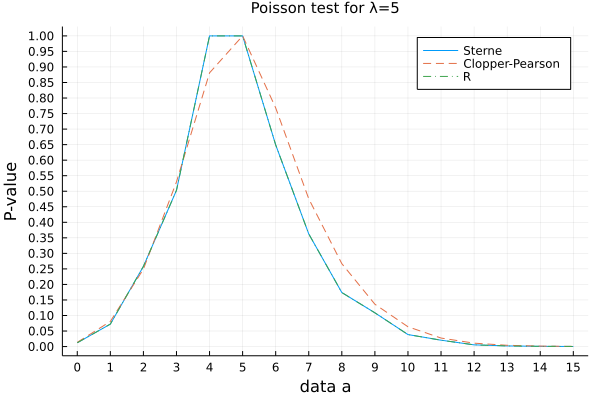

In [5]:
λ = 5
model = Poisson(λ)
datas = 0:15
pvals = [
    pvalue_sterne.(model, datas);;
    pvalue_clopper_pearson.(model, datas);;
    [rcopy(poisson_test(x, λ))[:p_value] for x in datas]
]
@show model datas
plot(datas, pvals; label, ls, xtick=datas, ytick, xguide="data a", yguide)
title!("Poisson test for λ=$λ")